In [1]:
import numpy as np
import pycbc.waveform as pycbc_wf
import bilby
import logging
logger = logging.getLogger(__name__)
import matplotlib.pyplot as plt

import pycbc

In [3]:
def time_domain_model(time_array, mass_1, mass_2, luminosity_distance, theta_jn, phase,
         a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, 
         **waveform_kwargs):
    """ Time Domain Model for the inspiral phase """
    
    start_frequency = minimum_frequency = waveform_kwargs.get('minimum_frequency', 20.0)
#    maximum_frequency = waveform_kwargs.get('maximum_frequency', frequency_array[-1])
    reference_frequency = waveform_kwargs.get('reference_frequency', 50.0)
    
#     waveform_dictionary = dict(spin_order=-1, tidal_order=-1,
#         phase_order=-1, amplitude_order=0)
    
    m1 = mass_1 * bilby.core.utils.solar_mass
    m2 = mass_2 * bilby.core.utils.solar_mass
    
    minimum_time = time_array[0]
    maximum_time = time_array[-1]
    
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
        theta_jn=theta_jn, phi_jl=phi_jl, tilt_1=tilt_1, tilt_2=tilt_2,
        phi_12=phi_12, a_1=a_1, a_2=a_2, mass_1=m1, mass_2=m2,
        reference_frequency=reference_frequency, phase=phase)

    longitude_ascending_nodes = 0.0
    mean_per_ano = 0.0
    
    delta_time = time_array[1] - time_array[0]
#     time_bounds = ((time_array >= minimum_time) *
#                         (time_array <= maximum_time))
    

    hplus, hcross = pycbc_wf.get_td_waveform( approximant = 'IMRPhenomPv2',#'SpinTaylorT4',
            mass1=mass_1, mass2=mass_2, spin1x=spin_1x,  spin1y=spin_1y, spin1z=spin_1z, 
            spin2x=spin_2x, spin2y=spin_2y, spin2z=spin_2z, distance=luminosity_distance, 
            inclination=iota, coa_phase=phase,  delta_t = delta_time,
            f_lower = start_frequency, f_ref=reference_frequency)
            #**waveform_dictionary)

    h_plus = np.zeros_like(time_array, dtype=complex)
    h_cross = np.zeros_like(time_array, dtype=complex)


    if len(hplus.data.data) > len(time_array):

        h_plus = hplus.data.data[:len(h_plus)]
        h_cross = hcross.data.data[:len(h_cross)]

        
    else:
        h_plus[-len(hplus.data.data):] = hplus.data.data
        h_cross[-len(hcross.data.data):] = hcross.data.data

#     h_plus *= time_bounds
#     h_cross *= time_bounds
    
    tindex = np.argmax(h_plus)
    zeros_length = len(h_plus[tindex:])
    
    h_plus = h_plus[:tindex]
    h_cross = h_cross[:tindex]
    
    h_plus = np.concatenate((np.zeros(zeros_length), h_plus))
    h_cross = np.concatenate((np.zeros(zeros_length), h_cross))
    



    return dict(plus=h_plus, cross=h_cross)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


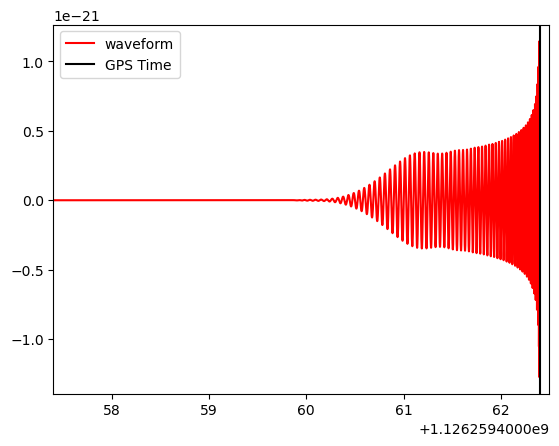

In [4]:
tg = 1126259462.4
t = np.arange(tg-10,tg,1/2048)
model = time_domain_model(t, 20, 30, 400, 0.3, 0.2,
         a_1=0.3, a_2=0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)['plus']

plt.plot(t,model,color='r',label='waveform')
plt.xlim([tg-5,tg+0.1])

plt.axvline(tg,color='k',label='GPS Time')
plt.legend()
plt.show()

In [4]:
tarr = np.arange(-4,0,1/2048)
tdwf = time_domain_model(tarr, 50, 30, 400, 0.3, 0.2,
         a_1=0.3, a_2=0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)['plus']

In [5]:
len(tdwf), len(tarr)

(8192, 8192)

In [5]:
injection_parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=2000.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)

In [6]:
duration = 4
sampling_frequency = 4096
outdir = "outdir"
label = "time_domain_source_model"

In [7]:
waveform = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    time_domain_source_model=time_domain_model,
    start_time=injection_parameters["geocent_time"] - duration,
)

22:21 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.time_domain_model
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [15]:
ifos.inject_signal??

In [9]:
ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])

In [11]:

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - duration,
)


In [12]:
ifos.inject_signal(
    waveform_generator=waveform, parameters=injection_parameters, raise_error=False
)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
21:59 bilby INFO    : Injected signal in H1:
21:59 bilby INFO    :   optimal SNR = 10.66
21:59 bilby INFO    :   matched filter SNR = 9.31-2.03j
21:59 bilby INFO    :   mass_1 = 36.0
21:59 bilby INFO    :   mass_2 = 29.0
21:59 bilby INFO    :   a_1 = 0.4
21:59 bilby INFO    :   a_2 = 0.3
21:59 bilby INFO    :   tilt_1 = 0.5
21:59 bilby INFO    :   tilt_2 = 1.0
21:59 bilby INFO    :   phi_12 = 1.7
21:59 bilby INFO    :   phi_jl = 0.3
21:59 bilby INFO    :   luminosity_distance = 2000.0
21:59 bilby INFO    :   theta_jn = 0.4
21:59 bilby INFO    :   psi = 2.659
21:59 bilby INFO    :   phase = 1.3
21:59 bilby INFO    :   geocent_time = 1126259642.413
21:59 bilby INFO    :   ra = 1.375
21:59 bilby INFO    :   dec = -1.2108
21:59 bilby INFO    : I

[{'plus': array([-8.69035149e-26+0.00000000e+00j, -8.69466412e-26-6.42188719e-28j,
         -8.70718031e-26-1.25786249e-27j, ...,
         -4.22533837e-26+1.28305041e-29j, -4.22543676e-26+6.30688512e-30j,
         -4.22547074e-26+0.00000000e+00j]),
  'cross': array([-2.87377094e-25+0.00000000e+00j, -2.87401907e-25-1.17706925e-30j,
         -2.87473473e-25+1.42267389e-29j, ...,
          9.79420316e-27+6.32040165e-30j,  9.79613642e-27+3.37323693e-30j,
          9.79680410e-27+0.00000000e+00j])},
 {'plus': array([-8.69035149e-26+0.00000000e+00j, -8.69466412e-26-6.42188719e-28j,
         -8.70718031e-26-1.25786249e-27j, ...,
         -4.22533837e-26+1.28305041e-29j, -4.22543676e-26+6.30688512e-30j,
         -4.22547074e-26+0.00000000e+00j]),
  'cross': array([-2.87377094e-25+0.00000000e+00j, -2.87401907e-25-1.17706925e-30j,
         -2.87473473e-25+1.42267389e-29j, ...,
          9.79420316e-27+6.32040165e-30j,  9.79613642e-27+3.37323693e-30j,
          9.79680410e-27+0.00000000e+00j])}]

In [19]:
dir(ifos[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_filename_from_outdir_label_extension',
 '_load_docstring',
 '_save_ifo_docstring',
 'amplitude_spectral_density_array',
 'antenna_response',
 'calibration_model',
 'check_signal_duration',
 'detector_tensor',
 'duration',
 'elevation',
 'frequency_array',
 'frequency_domain_strain',
 'frequency_mask',
 'from_hdf5',
 'from_pickle',
 'geometry',
 'get_detector_response',
 'inject_signal',
 'inject_signal_from_waveform_generator',
 'inject_signal_from_waveform_polarizations',
 'inner_product',
 'latitude',
 'latitude_radians',
 'length',
 'longitude',
 'longitude_radians',
 'matched_filter_snr',
 'maximum_frequency',
 'met

In [11]:
priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
]:
    priors[key] = injection_parameters[key]

17:58 bilby INFO    : No prior given, using default BBH priors in /cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [55]:
#priors.pop('chirp_mass')
#priors.pop('mass_ratio')

Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)

In [12]:
priors

{'mass_1': Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None),
 'mass_ratio': Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'chirp_mass': Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'luminosity_distance': UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None),
 'dec': -1.2108,
 'ra': 1.375,
 'theta_jn': Sine(minimum=0, maximum=3.141592653589793, name='theta_jn', latex_label='$\\theta_{JN}$', unit=None, boundary=None),
 'psi': 2.659,
 'phase': 1.3,
 'a_1': 0.4,
 'a_2': 0.3,
 'tilt_1': 0.5,
 'tilt_2': 1.0,
 'phi_12': 1.7,
 'phi_jl'

In [13]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(ifos, waveform)

In [ ]:
result = bilby.core.sampler.run_sampler(
    likelihood,
    priors,
    sampler="dynesty",
    npoints=1000,
    nlive = 100,
    #npool=8,
    nact=5,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
)


17:59 bilby INFO    : Running for label 'time_domain_source_model', output will be saved to 'outdir'
17:59 bilby INFO    : Using lal version 7.1.7
17:59 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
17:59 bilby INFO    : Using lalsimulation version 3.1.2
17:59 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
17:59 bilby INFO    : Search parameters:
17:59 bilby INFO    :   mass_ratio = Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
17:59 bilby INFO    :   chirp_mass = Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
17:59 bilby INFO    : 

0it [00:00, ?it/s]

17:59 bilby WARNING : Supplied argument 'npoints' not an argument of 'Dynesty', removing.
17:59 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 100, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fac7f3996a0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
17:59 bilby INFO    : Checkpoint every check_point_delta_t = 6

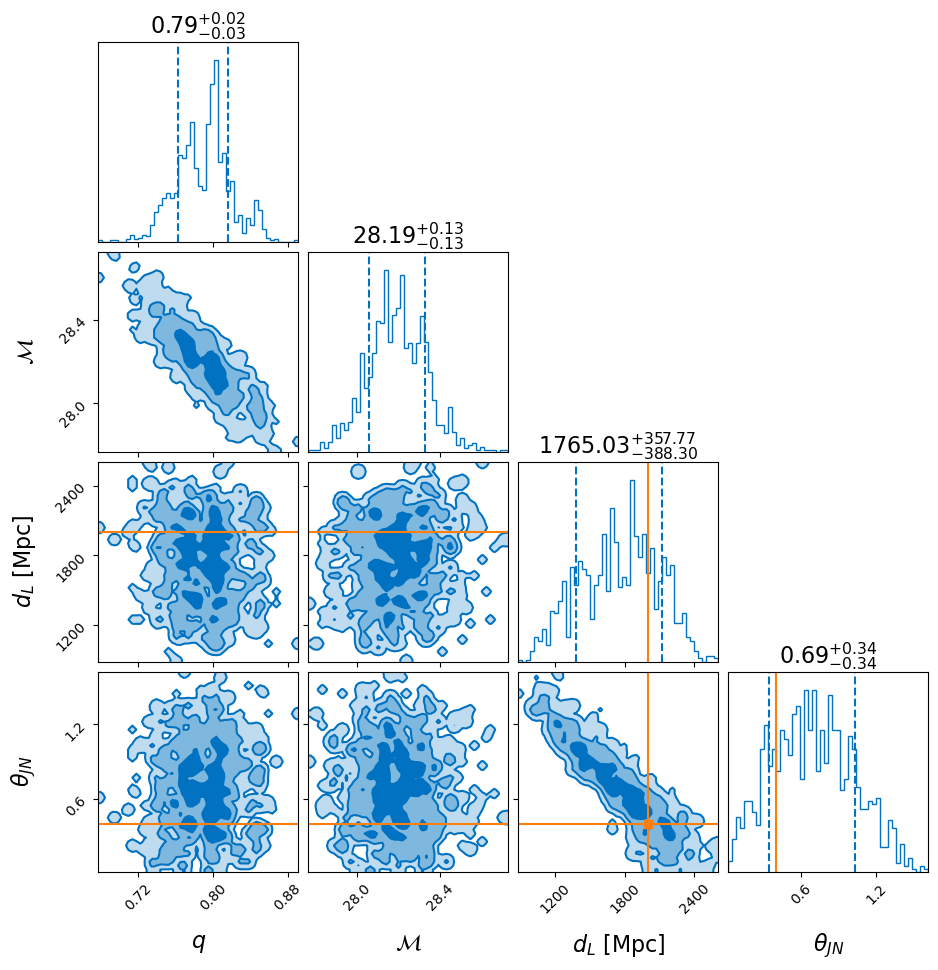

In [226]:
result.plot_corner()

In [134]:
import pandas as pd

In [156]:
#pd.set_option('display.max_columns', None)
file = pd.read_pickle('/home1/akash.mishra/Area_law/outdir/time_domain_source_model_dynesty.pickle')

In [157]:
file

       nlive: 50
       niter: 760
       ncall: array([  3,   1,   2,   2,   1,   2,   2,   1,   3,   2,   1,   1,   6,
         3,   2,   4,   1,   3,   1,   2,   2,   6,   1,   2,   5,   1,
         7,   2,   1,   7,   5,  15,   1,   3,   3,   4,   1,   2,   8,
         5,   2,   5,   1,   1,   5,  15,   6,   1,   4,   3,  10,   1,
         7,   1,   9,   5,   3,  23,   3,   5,   8,   7,  12,   7,  14,
        10,   9,   9,   6,   1,   2,   6,  28,  12,  14,   9,  18,  10,
         6,  21,   6,  10,  26,   2,  22,   9,  10,  11,   8,  24,   2,
         2,  39,  27,   5,  15,   6,   5,   2,  28,  29,   3,  21,  55,
        36,   4,  18,   1,  33, 116,  34, 133,  18,  18,   6,   6,   6,
         6,  18,   6,  18,   6,   6,  12,   6,   6,   6,   6,  12,   6,
         6,   6,   6,  12,   6,   6,  12,  12,  51,   9,   6,  13,   6,
         6,  12,  30,  24,  12,  25,   6,  13,   6,  18,   6,  20,   6,
        12,   6,   6,  12,   6,   7,  15,  54,  10,  34,  12,  12,  12,
        10,  21

In [237]:
res = bilby.core.result.Result(result)

In [238]:
dir(res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_prior_fixed_values_to_posterior',
 '_check_attribute_match_to_other_object',
 '_from_hdf5_old',
 '_get_save_data_dictionary',
 '_kde',
 '_load_doctstring',
 '_meta_data',
 '_nburn',
 '_nested_samples',
 '_num_likelihood_evaluations',
 '_posterior',
 '_priors',
 '_safe_outdir_creation',
 '_samples',
 '_version',
 '_walkers',
 'bayesian_model_dimensionality',
 'calculate_prior_values',
 'constraint_parameter_keys',
 'covariance_matrix',
 'fixed_parameter_keys',
 'from_hdf5',
 'from_json',
 'from_pickle',
 'get_all_injection_credible_levels',
 'get_injection_credible_level',
 'get_latex_labels_from_parameter_keys',
 'g

In [249]:
mass_rat = res.from_json('/home1/akash.mishra/Area_law/outdir/time_domain_source_model_result.json').posterior['mass_ratio']
dist = res.from_json('/home1/akash.mishra/Area_law/outdir/time_domain_source_model_result.json').posterior['luminosity_distance']

In [248]:
res.from_json('/home1/akash.mishra/Area_law/outdir/time_domain_source_model_result.json').posterior

,mass_ratio,chirp_mass,luminosity_distance,theta_jn,dec,ra,psi,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,geocent_time,log_likelihood,log_prior
0,0.818425,28.285993,2586.998417,0.128633,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,84.735630,-14.614351
1,0.677776,28.599423,2032.629707,0.626743,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,85.300137,-13.297345
2,0.762692,28.368148,1581.797569,1.299960,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,85.781443,-13.047963
3,0.762029,28.234650,880.161025,1.431215,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,86.177983,-13.727518
4,0.693929,28.729173,1923.866242,0.458838,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,86.497551,-13.629290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,0.800116,28.179365,1676.359129,0.708791,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,94.351186,-13.379858
1531,0.800116,28.179365,1676.359129,0.708791,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,94.351186,-13.379858
1532,0.801429,28.142835,1603.662040,0.799034,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,94.356188,-13.329517
1533,0.799139,28.172429,1708.787213,0.719447,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,94.412347,-13.348059


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  4.,  1., 11.,  3.,  7., 10.,
         6.,  8.,  0., 14., 11., 13., 11., 10., 20., 12., 28.,  0., 12.,
        30., 17., 22., 16., 17., 33., 16., 30., 18., 25.,  8., 13., 26.,
        12., 22., 21., 31., 32., 17., 18., 44., 32., 21., 38., 18., 19.,
        26., 16., 15., 23., 47., 43., 24., 38., 28., 24., 15., 48., 18.,
        26., 30., 26., 18.,  8., 19., 21., 36., 16., 23., 20., 32., 16.,
         9., 10., 13.,  6., 19.,  5.,  4.,  8.,  6.,  4.,  1.,  4.,  0.,
         2.,  0.,  0.,  3.,  0.,  1.,  2.,  1.,  1.]),
 array([ 880.1610252 ,  897.43477914,  914.70853308,  931.98228701,
         949.25604095,  966.52979489,  983.80354882, 1001.07730276,
        1018.3510567 , 1035.62481063, 1052.89856457, 1070.17231851,
        1087.44607245, 1104.71982638, 1121.99358032, 1139.26733426,
        1156.54108819, 1173.81484213, 1191.08859607, 1208.36235   ,
        1225.63610394, 1242.90985788, 1260.18361182, 1277.45736575,
        1294.73111969, 131

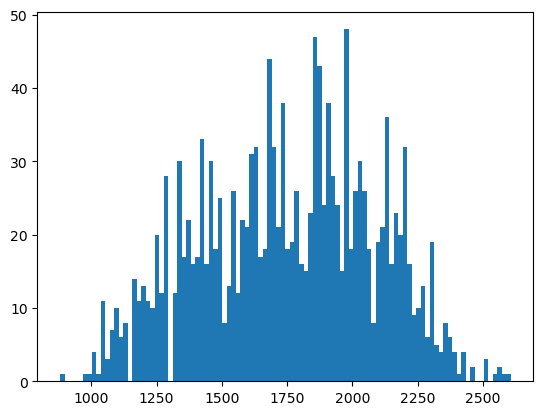

In [251]:
plt.hist(dist, bins = 100)

In [14]:
bilby.gw.likelihood.GravitationalWaveTransient??